# IBM Quantum Experience Lab - Lab script

Please use this notebook as a template for the work that you will submit for assessment for this lab exercise.

Student Names: Parth Bhandari
               Sheila Perez 
               Charlie Solomons-Tuke

## Warm up exercise

In [81]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.tools.visualization import circuit_drawer
import numpy as np
import time

In [2]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.measure(qr[0],cr[0])

backend = Aer.get_backend('qasm_simulator')

exponent = np.arange(2,20,1) # 2^25 iterations is as much as I can calulate in a reasonable amound of time.
expectation = []
for s in [2**n for n in exponent]:
    job = execute(circuit, backend, shots=s)
    result=job.result().get_counts(circuit)
    expectation.append((result['0']-result['1'])/(result['0']+result['1']))

Text(0.5, 0, 'log2(number of itterations)')

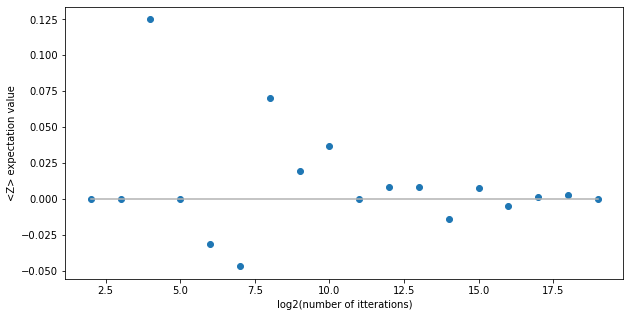

In [3]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.scatter(exponent, expectation)
ax.plot(exponent, exponent*0, c=(0.7,.7,0.7))
ax.set_ylabel('<Z> expectation value')
ax.set_xlabel('log2(number of itterations)')

# Main exercise

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Let us first figure out what we are expecting from our circuit.

The expectation value for any pair $(\theta, \phi)$ can be calculated explicitly;

\begin{equation}
\bra{\phi}M(\theta)\ket{\phi}=\begin{pmatrix} \cos(\phi) & -i\sin(\phi) \end{pmatrix}
\begin{pmatrix} 0 & e^{-i\theta} \\ e^{i\theta} & 0 \end{pmatrix}
\begin{pmatrix} \cos(\phi) \\ i\sin(\phi) \end{pmatrix}
= i\cos(\phi)\sin(\phi)(e^{-i\theta} - e^{i\theta}) = \sin(2\phi)\sin(\theta)
\end{equation}

In [4]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer
from qiskit.visualization import circuit_drawer
import numpy as np

In [5]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)
backend = Aer.get_backend('qasm_simulator')

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

## Pair 1:  𝜃=𝜋/4,  𝜙=0

When $\phi=0$ the state is simply $\ket{0}$.

For $\theta = \pi /4$, the observable in question is

$$ M(\pi/4) = \begin{bmatrix} 0 & \frac{1-i}{\sqrt{2}} \\ \frac{1+i}{\sqrt{2}} & 0
\end{bmatrix}$$

and from above we have that $\langle M\rangle = 0$

### Method 2

We use the identity $M(\pi/4) = \frac{1}{\sqrt{2}} X + Y $, then estimate $X$ and $Y$ independently.

Below we define functions for measuring x and y given a circuit and a clasical bit to perform the measurement on.

In [6]:
def measure_z(circuit, c_bit, shots=1024):
    circuit.measure([0],c_bit)
    job = execute(circuit, backend, shots=shots)
    result = job.result().get_counts(circuit) 
    keys = list(result.keys())
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1'])   
    elif keys == ['0']:
        return 1.0
    elif keys == ['1']:
        return -1.0

def measure_x(circuit, c_bit, shots=1024):
    circuit.h([0])
    circuit.measure([0],c_bit)
    job = execute(circuit, backend, shots=shots)
    result = job.result().get_counts(circuit)
    keys = list(result.keys())
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1'])   
    elif keys == ['0']:
        return 1.0
    elif keys == ['1']:
        return -1.0


def measure_y(circuit, c_bit, shots=1024):
    circuit.s([0])
    circuit.s([0])
    circuit.s([0]) # using S^-1 = S^3
    circuit.h([0])
    circuit.measure([0],c_bit)
    job = execute(circuit, backend, shots=shots)
    result = job.result().get_counts(circuit) 
    keys = list(result.keys())
    if set(keys) == set(['0','1']):
        return (result['0']-result['1'])/(result['0']+result['1'])   
    elif keys == ['0']:
        return 1.0
    elif keys == ['1']:
        return -1.0

def measure_method_2(theta, circuit, qr, cr, shots=1024):
    xcircuit = circuit.copy()
    x = measure_x(xcircuit, cr[0], shots=shots)
    ycircuit = circuit.copy()
    circuit_drawer(ycircuit)
    y = measure_y(ycircuit, cr[0], shots=shots)
    M = np.cos(theta)*x + np.sin(theta)*y
    return M

In [7]:
circuit = QuantumCircuit(qr, cr)
M = measure_method_2(np.pi/4, circuit, qr, cr)

print(M)


0.02209708691207961


### Method 1

Note that $M = U(\theta)XU(\theta)^\dagger = U(\theta)HZHU(\theta)^\dagger$, so to measure M we just need to apply $HU(\theta)^\dagger$, and then measure $Z$. For $\theta = \pi/4$, $HU(\pi/4)^\dagger = HT^\dagger$

In [8]:
def measure_method_1(theta, circuit, qr, cr, shots=1024):
    zcircuit = circuit.copy()
    zcircuit.p(-theta, [0])
    zcircuit.h([0])
    M = measure_z(zcircuit, cr[0], shots=shots)
    return M

qr = QuantumRegister(1)
cr = ClassicalRegister(1)
zcircuit = QuantumCircuit(qr, cr)
M = measure_method_1(np.pi/4, zcircuit, qr, cr)
print(M)

0.01171875


## Pair 2:  𝜃=𝜋/8,  𝜙=𝜋/4

For $\phi = \pi/4$ the input state is $\frac{1}{\sqrt{2}}(\ket{0} + i\ket{1}) = \mathrm{exp}(-i\pi/4)HU(-\pi/2)H\ket{0}$. 

The formula above gives $\langle M\rangle = \sin(\pi/8) \approx 0.3827$.

To initialise the state we use the following function:

In [89]:
def init_circuit(phi, qr, cr):
    circuit = QuantumCircuit(qr, cr)
    circuit.h([0])
    circuit.p(-2*phi, [0])
    circuit.h([0]) # Ignoring global phase
    return circuit
    
N = 5000

In [90]:
# Method 1

zcircuit = init_circuit(np.pi/4, qr, cr)
M1 = []
start=time.time()
for i in range(N):
    M1.append(measure_method_1(np.pi/8, zcircuit, qr, cr))
t1 = time.time()-start
print(f'Method 1: Time elapsed for {N} iterations: ', t1)


Method 1: Time elapsed for 5000 iterations:  43.23


In [91]:
# Method 2

circuit = init_circuit(np.pi/4, qr, cr)
M2 = []
start=time.time()
for i in range(N):
    M2.append(measure_method_2(np.pi/8, circuit, qr, cr))
t2 = time.time()-start
print(f'Method 2: Time elapsed for {N} iterations: ', t2)

Method 2: Time elapsed for 5000 iterations:  85.1


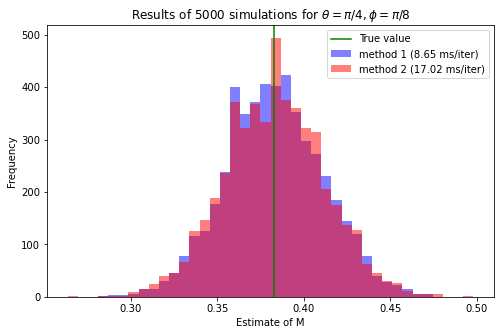

In [101]:
fig1, ax1 = plt.subplots(figsize=(8,5))
bins=np.histogram(np.hstack((M1,M2)), bins=40)[1]
ax1.hist(M1, bins, color='b', alpha=0.5, label=f'method 1 ({round(t1/N*1000, 2)} ms/iter)')
ax1.hist(M2, bins, color='r', alpha=0.5, label=f'method 2 ({round(t2/N*1000, 2)} ms/iter)')
ax1.axvline(0.3827, linestyle='-', c='g', label='True value')
ax1.set_xlabel('Estimate of M')
ax1.set_ylabel('Frequency')
ax1.set_title(f'Results of {N} simulations for '+r'$\theta=\pi/4, \phi=\pi/8$')
ax1.legend()